In [1]:
import os
import pickle
from tqdm import tqdm
import sentencepiece as spm

In [4]:
import gzip
fname = 'data/conceptnet5/conceptnet-assertions-5.7.0.csv.gz'
f = gzip.open(fname)

In [5]:
lines = []
for line in f:
    lines.append(line)
f.close()

In [6]:
len(lines)

34074917

In [18]:
lines[-100].decode().split('\t')[1:4]

['/r/dbpedia/product', '/c/en/sony', '/c/en/semiconductor']

In [19]:
from tqdm.notebook import tqdm
import json

triples_reduced = []
for line in tqdm(lines):
    line = line.decode().split('\t')
    line = line[1:4]
    if '/en/' in line[1] and '/en/' in line[2]:
        triples_reduced.append([line[1], line[0], line[2]])

In [20]:
len(triples_reduced)

3480905

In [24]:
triples_no_dbpedia = []
for t in tqdm(triples_reduced):
    if 'r/dbpedia/' not in t[1]:
        triples_no_dbpedia.append(t)

In [25]:
len(triples_no_dbpedia)

3468600

In [29]:
triples = triples_no_dbpedia

In [26]:
triples_no_dbpedia[-20:]

[['/c/en/yoyo', '/r/UsedFor', '/c/en/spinning'],
 ['/c/en/yoyo', '/r/UsedFor', '/c/en/walking_dog'],
 ['/c/en/yoyo', '/r/UsedFor', '/c/en/wearing_on_finger'],
 ['/c/en/zipper', '/r/UsedFor', '/c/en/fasten_pants'],
 ['/c/en/zippers', '/r/UsedFor', '/c/en/fasten_coats'],
 ['/c/en/zippers', '/r/UsedFor', '/c/en/fasten_jackets'],
 ['/c/en/zippers', '/r/UsedFor', '/c/en/fasten_pants'],
 ['/c/en/zombie_programs', '/r/UsedFor', '/c/en/attack_other_computers'],
 ['/c/en/zoom_lens', '/r/UsedFor', '/c/en/bringing_distant_object_into_focus'],
 ['/c/en/zoom_lens', '/r/UsedFor', '/c/en/capturing_distant_object_on_film'],
 ['/c/en/zoom_lens', '/r/UsedFor', '/c/en/examine_in_greater_detail'],
 ['/c/en/zoom_lens', '/r/UsedFor', '/c/en/get_better_photographs'],
 ['/c/en/zoom_lens', '/r/UsedFor', '/c/en/making_objects_appear_closer'],
 ['/c/en/zoom_lens', '/r/UsedFor', '/c/en/observing_distant_object'],
 ['/c/en/zoom_lens', '/r/UsedFor', '/c/en/photography'],
 ['/c/en/zoom_lens', '/r/UsedFor', '/c/en/pr

In [28]:
import random
random.sample(triples_no_dbpedia,30)

[['/c/en/pagan/n', '/r/RelatedTo', '/c/en/bagan'],
 ['/c/en/kissing', '/r/Causes', '/c/en/sex'],
 ['/c/en/head', '/r/PartOf', '/c/en/human_body'],
 ['/c/en/textbook/a', '/r/RelatedTo', '/c/en/dry'],
 ['/c/en/vasudevans/n', '/r/FormOf', '/c/en/vasudevan'],
 ['/c/en/tzarist/n', '/r/FormOf', '/c/en/tsarist'],
 ['/c/en/cable/n', '/r/HasContext', '/c/en/material'],
 ['/c/en/microscrew', '/r/DerivedFrom', '/c/en/screw'],
 ['/c/en/ighv/n', '/r/RelatedTo', '/c/en/chain'],
 ['/c/en/radiocardiograms/n', '/r/FormOf', '/c/en/radiocardiogram'],
 ['/c/en/pneumaticity/n', '/r/HasContext', '/c/en/biology'],
 ['/c/en/playing_cards', '/r/Causes', '/c/en/amusement'],
 ['/c/en/people_with_arthritis', '/r/HasA', '/c/en/difficulty_walking'],
 ['/c/en/mud_bogs/n', '/r/FormOf', '/c/en/mud_bog'],
 ['/c/en/basilisks/n', '/r/RelatedTo', '/c/en/basilisk'],
 ['/c/en/prezygotically/r', '/r/Antonym', '/c/en/postzygotically'],
 ['/c/en/hwbs/n', '/r/FormOf', '/c/en/hwb'],
 ['/c/en/line_of_succession/n', '/r/RelatedTo'

In [30]:
relations = set()
for t in triples:
    relations.add(t[1])

In [31]:
len(relations)

38

In [45]:
def camel_case_split(str):
    words = [[str[0]]]
    for c in str[1:]:
        if words[-1][-1].islower() and c.isupper():
            words.append(list(c))
        else:
            words[-1].append(c)
    return [''.join(word) for word in words]


def getConceptName(c_uri):
    name = c_uri[6:].split('/')[0]
    name = name.replace('_', ' ')
    return name

def getRelationName(r_uri):
    name = ' '.join(camel_case_split(r_uri[3:]))
    return name

def tripleToNamedTuple(t):
    return (getConceptName(t[0]), getRelationName(t[1]), getConceptName(t[2]))

In [46]:
named_triples = []
for t in tqdm(triples):
    t2 = tripleToNamedTuple(t)
    named_triples.append(t2)

In [47]:
len(set(named_triples))

3366575

In [48]:
named_triples = list(set(named_triples))

In [49]:
random.shuffle(named_triples)

In [50]:
data = {}
data['train'] = named_triples[10000:]
data['test'] = named_triples[:5000]
data['valid'] = named_triples[5000:10000]

In [51]:
data['train'][0]

('defence', 'Synonym', 'defending')

In [55]:
out_folder = '/scratche/home/apoorv/transformer-kgc/data/conceptnet5'
splits = ['train', 'test', 'valid']

count = 0
for split in splits:
    fname = os.path.join(out_folder, split + '.txt')
    f = open(fname, 'w')
    triples = data[split]
    for t in triples:
        head, relation, tail = t
        input = 'predict: {0} | {1}'.format(head, relation)
        output = '{}'.format(tail)
        f.write(input + '\t' + output + '\n')
        
        input = 'predict head: {0} | {1}'.format(tail, relation)
        output = '{}'.format(head)
        f.write(input + '\t' + output + '\n')
    f.close()

In [107]:
count

1019066

In [52]:
entity_names = set()
for t in named_triples:
    entity_names.add(t[0])
    entity_names.add(t[2])
len(entity_names)

1165187

In [54]:
# create entity_strings.txt which is needed in evaluation code
out_folder = 'data/conceptnet5'
strings_file_name = 'entity_strings.txt'
f = open(os.path.join(out_folder, strings_file_name), 'w')
ents_uniq = entity_names
for e in ents_uniq:
    f.write(e + '\n')
f.close()

In [99]:
# webqsp qa 
# def readQALines(fname):
#     f = open(fname)
#     questions = []
#     for line in f:
#         line = line.strip().split('\t')
#         q = line[0]
#         lhs = q.split('[')[0]
#         rhs = q.split(']')[1]
#         only_question = lhs + 'NE' + rhs
#         only_question = normalizeEntity(only_question)
# #         q = q.replace('[', '')
# #         q = q.replace(']', '')
# #         q = normalizeEntity(q)
#         questions.append(only_question)
#     return questions
        
# def writeLines(lines, fname):
#     f = open(fname, 'w')
#     for line in lines:
#         f.write(line + '\n')


'what character did natalie portman play in star wars NE'

In [81]:
# fname = 'data/MetaQA/full_qa.txt'
# questions = readQALines(fname)
# questions = list(set(questions))

In [82]:
# fname = 'data/MetaQA/only_questions_text.txt'
# writeLines(questions, fname)

In [138]:
vocab_size = 30000
sp = spm.SentencePieceTrainer.train(input='data/fbwq_half/train.txt', 
                                    model_prefix='fbwq_with_pad', vocab_size=vocab_size, 
                                    pad_id=3,
#                                     character_coverage=1.0,
#                                user_defined_symbols=['predict',
#                                                     'head',
#                                                     'tail',
#                                                     '|'],
#                                     normalization_rule_name='identity',
                              )

In [139]:
# sp = spm.SentencePieceProcessor(model_file='data/sentencepiece/metaqa_with_pad.model')
sp = spm.SentencePieceProcessor(model_file='fbwq_with_pad.model')

In [38]:
# sp['Obama']

0

In [151]:
sp.decode(sp.encode('how old'))

'how old'

In [192]:
sp.encode('<pad>')

[5, 0, 12497, 0]

In [195]:
sp['</s>']

2

In [193]:
sp.id_to_piece(3)

'<pad>'

In [176]:
lengths = []
count = 0
for e in tqdm(ents_uniq):
    encoded = sp.encode(e)
    l = len(encoded)
    if l > 500:
        print(e,l)
        l = 20
        count += 1
    lengths.append(l)
count

100%|██████████| 1712213/1712213 [00:18<00:00, 91029.72it/s] 


0

Text(0.5, 0, 'Tokenized lengths')

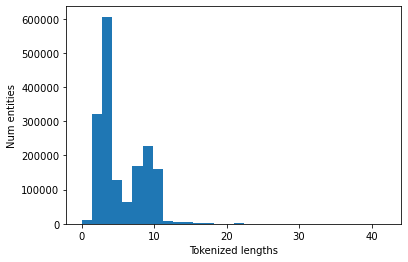

In [177]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [190]:
lengths = []
count = 0
for e in tqdm(relations):
    encoded = sp.encode(relation_map[e])
    l = len(encoded)
    if l > 10:
        print(relation_map[e])
        count +=1
    lengths.append(l)
count

100%|██████████| 1068/1068 [00:00<00:00, 41292.34it/s]

astronomical objects discovered
astronomical objects discovered reverse
sewage treatment plant
sewage treatment plant reverse
infidelity perpetrator reverse
substance abuse reverse
lifetime batting statistics reverse
sponsored by reverse
substance abuse problems reverse
appears in these fictional universes reverse
jurisdiction of office reverse
body this is a component of reverse
politicians in this party reverse
websites owned reverse
tropical cyclone season reverse
olympics hosted reverse
types of places of worship reverse
athletic performances reverse
mode of transportation reverse
appeared in tv episodes reverse
episodes appeared in reverse


21

Text(0.5, 0, 'Tokenized lengths')

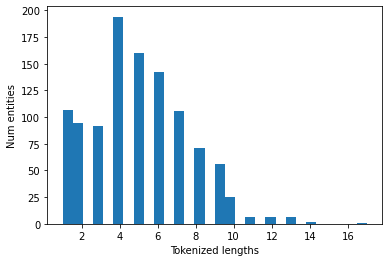

In [186]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [191]:
sp.encode('plays for')

[167, 10, 96]

In [104]:
len(uniq_ent_map)

1880592

In [143]:
def replaceEntities(line, aliases_dict):
    line = line.strip().split('\t')
    q = line[0]
    # sometimes no answer
    if len(line) > 1:
        answers= line[1].split('|')
    else:
        answers = []    
    lhs = q.split('[')[0]
    rhs = q.split(']')[1]
    head_id = q.split('[')[1].split(']')[0]
    if head_id in aliases_dict:
        head_text = aliases_dict[head_id]
    else:
        head_text = head_id
        print(head_text + ' not found')
    answers_text = []
    for a in answers:
        if a in aliases_dict:
            answers_text.append(aliases_dict[a])
        else:
            answers_text.append(a)
    answers_string = '|'.join(answers_text)
    
    out = '{lhs}[{head}]{rhs}\t{ans}'.format(
        lhs=lhs,
        rhs=rhs,
        head = head_text,
        ans = answers_string
    )
    return out
        
def readLines(fname):
    f = open(fname)
    lines = []
    for line in f:
        lines.append(line.rstrip())
    f.close()
    return lines

def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')
    f.close()

In [137]:
# need to make qa data as well, since entity aliases need to be used
# and not just entity ids as answers
fname = '/scratche/home/apoorv/EmbedKGQA/data/QA_data/WebQuestionsSP/qa_test_webqsp_fixed.txt'
questions = readLines(fname)


In [138]:
questions[1]

'what did james k polk do before he was president [m.042f1]\tm.02_bcst|m.04x_n9q|m.0cgqx'

In [144]:
lines_with_entities = [replaceEntities(q, uniq_ent_map) for q in questions]

m.02vkmj9 not found


In [145]:
len(lines_with_entities)

1639

In [146]:
lines_with_entities[:10]

['what does jamaican people speak [Jamaica 1]\tJamaican English|Jamaican Creole English Langua|Jamaican English',
 'what did james k polk do before he was president [James K. Polk]\tUnited States Representative|Governor of Tennessee|Speaker of the United States H',
 'who plays ken barlow in coronation street [Coronation Street]\tWilliam Roache',
 'where is jamarcus russell from [JaMarcus Russell]\tMobile 0',
 'where was george washington carver from [George Washington Carver]\tDiamond 8',
 'what else did ben franklin invent [Benjamin Franklin]\tLightning rod|Bifocals|Glass harmonica|Franklin stove',
 'who was richard nixon married to [Richard Nixon]\tPat Nixon',
 'who is governor of ohio 2011 [Ohio 2]\tJohn Kasich|Return J. Meigs, Jr.|Ted Strickland',
 'who was vice president after kennedy died [John F. Kennedy 0]\tLyndon B. Johnson 1',
 'where is the fukushima daiichi nuclear plant located [Fukushima Daiichi Nuclear Powe]\tJapan 1|Okuma']

In [148]:
fname = 'data/fbwq_half/qa_valid_1hop.txt'
writeLines(lines_with_entities, fname)